In [1]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import evautils
from evautils import sequtils
from evautils import kerasutils

Using TensorFlow backend.


In [3]:
POSITIVE_SEQUENCES_FILE="/users/eprakash/benchmarking/H1ESC/400bp_hg38/preprocessing/implanted_H1ESC_400.bed.gz"
POSITIVE_SEQUENCES_5K_SUBSET_LABELS="/users/eprakash/benchmarking/H1ESC/400bp_hg38/deeplift/H1ESC_400_top_5K_pos_labels.h5"
ISM_LABELS_FILE="/users/eprakash/benchmarking/H1ESC/400bp_hg38/results/ISM_deepseabeluga_H1ESC_positive.labels.5K.txt"
MOMMA_DRAGONN_MODEL_FILE="/users/eprakash/benchmarking/H1ESC/400bp_hg38/training/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_XHjBt_modelJson.json"
MOMMA_DRAGONN_WEIGHTS_FILE="/users/eprakash/benchmarking/H1ESC/400bp_hg38/training/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_XHjBt_modelWeights.h5"
DEEPLIFT_SCORES_FILE="/users/eprakash/benchmarking/H1ESC/400bp_hg38/deeplift/H1ESC_400_dl_scores_5K.h5"
ISM_SCORES_FILE="/users/eprakash/benchmarking/H1ESC/400bp_hg38/results/H1ESC.deepseabeluga.ISM.scores.5K.npy"

In [4]:
import numpy as np
from collections import OrderedDict
import h5py

positives=sequtils.load_sequences_from_bedfile(POSITIVE_SEQUENCES_FILE)
labeled_sequences = sequtils.load_sequences_from_bedfile(POSITIVE_SEQUENCES_FILE)
print("Got %d positive sequences" % len(labeled_sequences))

#Prune labeled sequences down to the 5K selected labels used in the other scoring methods
h5f = h5py.File(POSITIVE_SEQUENCES_5K_SUBSET_LABELS,'r')
positive_labels_5K=set(h5f.get("labels"))
selected_sequences = OrderedDict()
for lbl in labeled_sequences.keys():
    if (lbl in positive_labels_5K):
        selected_sequences.update({lbl:labeled_sequences[lbl]})
labeled_sequences = selected_sequences
        
print("Selected %d positive sequences" % len(labeled_sequences))
positive_labels = labeled_sequences.keys()
labels = labeled_sequences.keys()
sequences=labeled_sequences.values()
print("Sequences length: ", len(sequences))

#Loading /users/eprakash/benchmarking/H1ESC/400bp_hg38/preprocessing/implanted_H1ESC_400.bed.gz ...
#Loaded 96663 sequences from /users/eprakash/benchmarking/H1ESC/400bp_hg38/preprocessing/implanted_H1ESC_400.bed.gz
#Loading /users/eprakash/benchmarking/H1ESC/400bp_hg38/preprocessing/implanted_H1ESC_400.bed.gz ...
#Loaded 96663 sequences from /users/eprakash/benchmarking/H1ESC/400bp_hg38/preprocessing/implanted_H1ESC_400.bed.gz
Got 96663 positive sequences
Selected 5000 positive sequences
Sequences length:  5000


In [5]:
sequtils.removeUnsupportedChars(sequences, labels, labeled_sequences)

5000
5000
5000
5000


In [6]:
sequtils.save_labels(labeled_sequences, ISM_LABELS_FILE)

<class 'collections.OrderedDict'>


In [7]:
onehot_data = np.array([sequtils.one_hot_encode_along_channel_axis(seq) for seq in sequences])
print(onehot_data.shape)

(5000, 400, 4)


In [8]:
keras_model=kerasutils.load_keras_model_using_json(MOMMA_DRAGONN_MODEL_FILE, MOMMA_DRAGONN_WEIGHTS_FILE)
keras_model.summary()

Loading Keras JSON model from file /users/eprakash/benchmarking/H1ESC/400bp_hg38/training/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_XHjBt_modelJson.json
Loading Keras model weights from file /users/eprakash/benchmarking/H1ESC/400bp_hg38/training/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_XHjBt_modelWeights.h5
Successfully loaded
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 393, 320)          10560     
_________________________________________________________________
activation_1 (Activation)    (None, 393, 320)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 386, 320)          819520    
_________________________________________________________________
activation_2 (Activation)    (None, 386, 320)          0  

In [9]:
preds = keras_model.predict(onehot_data)
preds.shape

(5000, 1)

In [10]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.layers import NonlinearMxtsMode

deeplift_rescale_model = kerasutils.createDLModel(MOMMA_DRAGONN_WEIGHTS_FILE, MOMMA_DRAGONN_MODEL_FILE, NonlinearMxtsMode.Rescale)

nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func


In [11]:
deeplift_rescale_model.get_layers()[-2].get_shape()

(None, 1)

In [12]:
import h5py
h5f = h5py.File(DEEPLIFT_SCORES_FILE,'r')

In [13]:
rescale_all_multiref_scores=np.array(h5f.get("rescale_all_layers_multiref_10"))
h5f.close()

In [14]:
rescale_all_multiref_scores.shape

(5000, 400)

In [15]:
onehot_data.shape

(5000, 400, 4)

In [16]:
np.argmax(np.sum(rescale_all_multiref_scores, axis=(1)))

4999

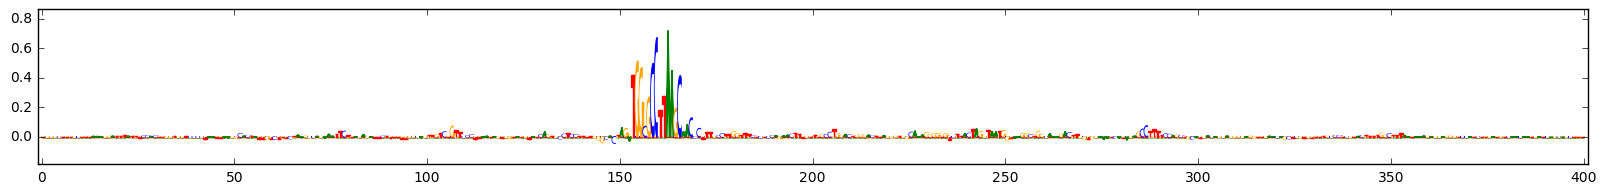

In [17]:
%matplotlib inline
from deeplift.visualization import viz_sequence
idx = 4022
viz_sequence.plot_weights(rescale_all_multiref_scores[idx][:,None]*onehot_data[idx], subticks_frequency=50)

In [18]:
deeplift_prediction_func = deeplift.util.compile_func(
    inputs=[deeplift_rescale_model.get_layers()[0].get_activation_vars()],
    outputs=deeplift_rescale_model.get_layers()[-2].get_activation_vars()[:,0])

In [19]:
ism_func = kerasutils.make_ism_func(prediction_func=deeplift_prediction_func,
                         flank_around_middle_to_perturb=200,
                         batch_size=200)

In [20]:
scores_ism_oneregion = ism_func([onehot_data[idx:idx+1]])

In [21]:
scores_ism_oneregion.shape

(1, 400, 4)

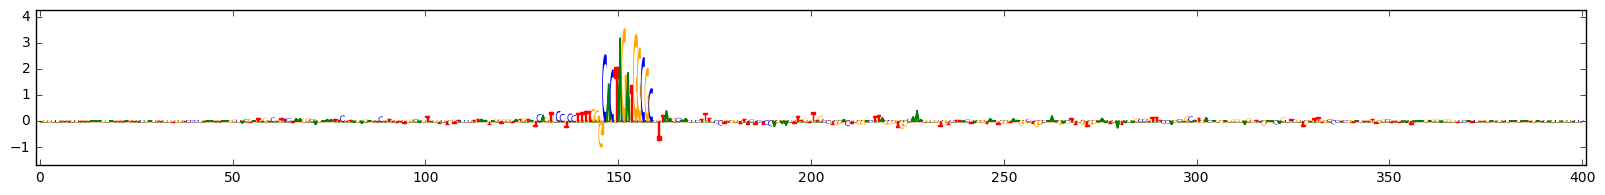

In [22]:
viz_sequence.plot_weights(scores_ism_oneregion[0], subticks_frequency=50)

In [23]:
#kerasutils.sanityCheckGivenPredFunc(deeplift_prediction_func, onehot_data, keras_model)

In [24]:
scores_ism = np.array(ism_func(input_data_list=[onehot_data],
                                       progress_update=10000))

('Done', 10000)
('Done', 20000)
('Done', 30000)
('Done', 40000)
('Done', 50000)
('Done', 60000)
('Done', 70000)
('Done', 80000)
('Done', 90000)
('Done', 100000)
('Done', 110000)
('Done', 120000)
('Done', 130000)
('Done', 140000)
('Done', 150000)
('Done', 160000)
('Done', 170000)
('Done', 180000)
('Done', 190000)
('Done', 200000)
('Done', 210000)
('Done', 220000)
('Done', 230000)
('Done', 240000)
('Done', 250000)
('Done', 260000)
('Done', 270000)
('Done', 280000)
('Done', 290000)
('Done', 300000)
('Done', 310000)
('Done', 320000)
('Done', 330000)
('Done', 340000)
('Done', 350000)
('Done', 360000)
('Done', 370000)
('Done', 380000)
('Done', 390000)
('Done', 400000)
('Done', 410000)
('Done', 420000)
('Done', 430000)
('Done', 440000)
('Done', 450000)
('Done', 460000)
('Done', 470000)
('Done', 480000)
('Done', 490000)
('Done', 500000)
('Done', 510000)
('Done', 520000)
('Done', 530000)
('Done', 540000)
('Done', 550000)
('Done', 560000)
('Done', 570000)
('Done', 580000)
('Done', 590000)
('Done

In [25]:
print(scores_ism.shape)

(5000, 400, 4)


In [26]:
print(scores_ism[2144])

[[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.64747238e-04]
 [ 0.00000000e+00  6.69002533e-04 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  4.08887863e-04]
 ...
 [-0.00000000e+00 -0.00000000e+00  1.43051147e-06 -0.00000000e+00]
 [-0.00000000e+00  7.15255737e-07 -0.00000000e+00  0.00000000e+00]
 [ 4.76837158e-07 -0.00000000e+00 -0.00000000e+00  0.00000000e+00]]


In [27]:
np.save(ISM_SCORES_FILE, scores_ism)